Please enter the stock ticker symbol (e.g., MSFT): WAB


[*********************100%***********************]  1 of 1 completed

Step 1: Fetching and preparing data...
Data fetched for WAB from 2015-01-01 to 2023-12-31.

Step 2: Training and optimizing the model on the training data...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


Best hyperparameters found: {'max_depth': None, 'n_estimators': 50}
Model accuracy on the test set: 100.00%

Step 3: Performing backtesting of the strategy with risk management...

Step 4: Calculating metrics and visualizing results...

--- Performance Metrics ---
Total Return (Strategy): -0.24%
Total Return (Benchmark): 33.47%
Sharpe Ratio: -0.06
Max Drawdown: -4.57%
Total Trades: 127
Winning Trades: 78
Losing Trades: 49
Win Rate: 61.42%
Average Win: 1.45%
Average Loss: -1.48%


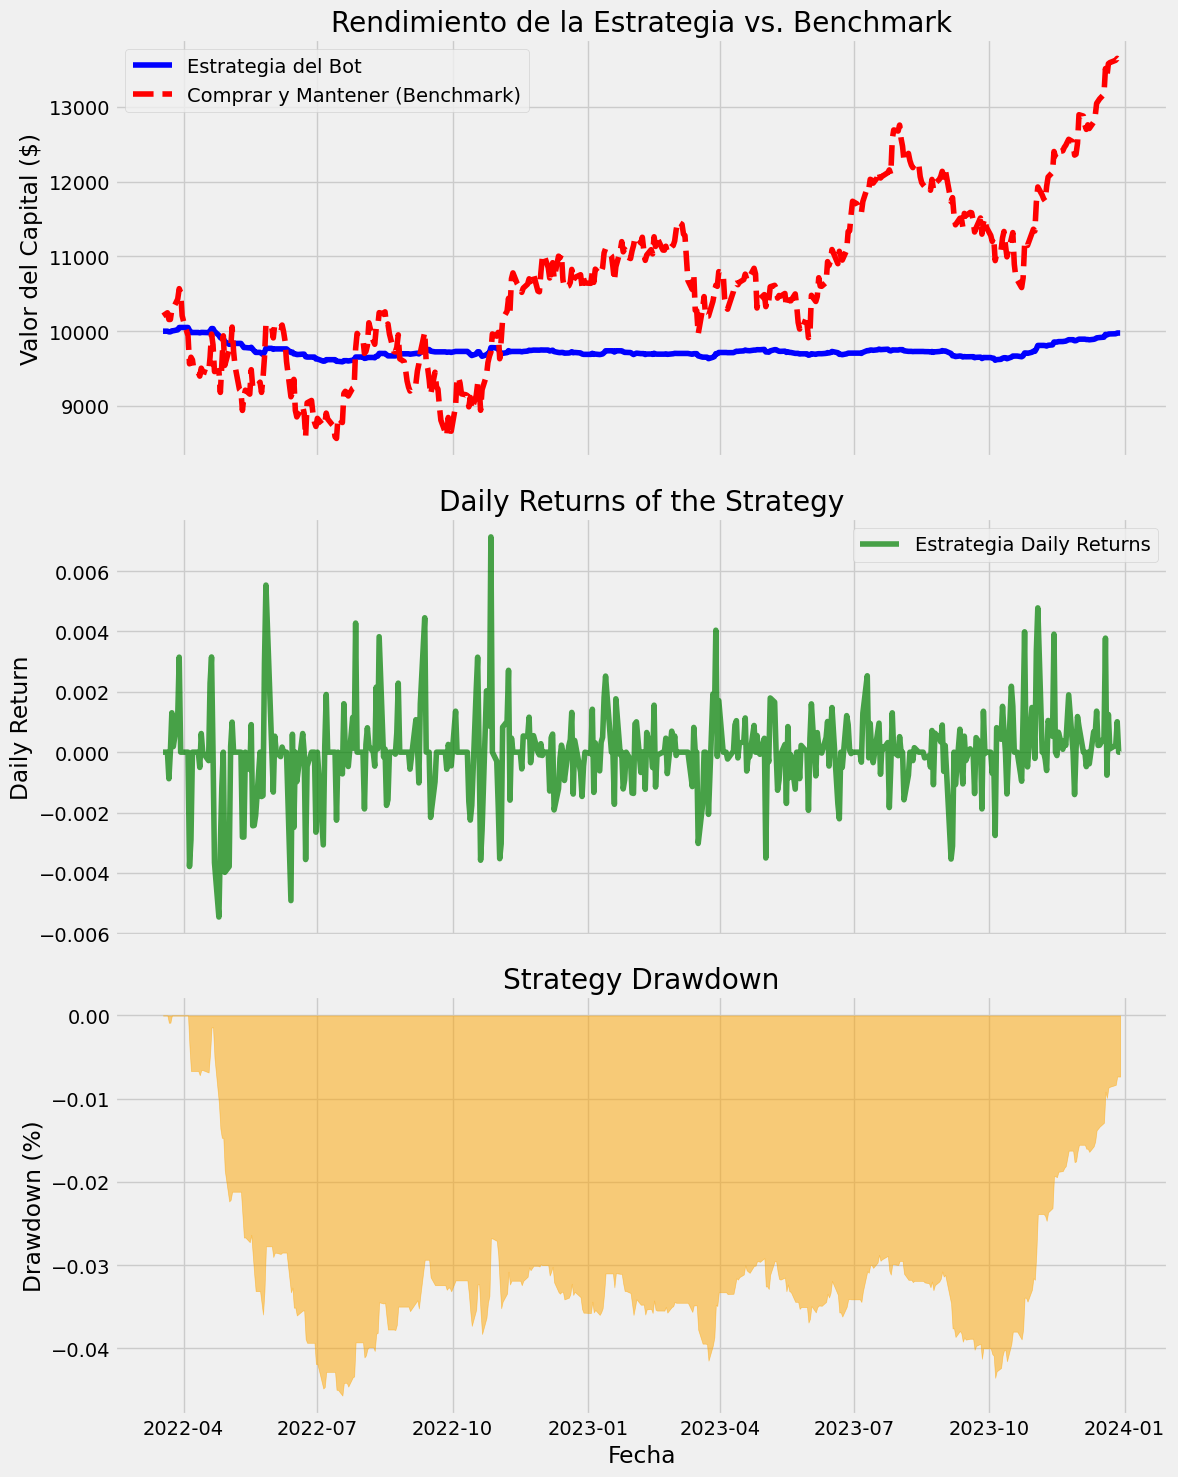


Backtesting completed. Review the plots and metrics for performance analysis.


In [23]:
# -*- coding: utf-8 -*-
#
# Advanced Trading Bot Framework
#
# This script demonstrates a sophisticated approach to algorithmic trading,
# utilizing machine learning to predict market movements.
# It is designed as a framework for research and backtesting, not for live trading.
#
# Key features:
# 1. Fetching historical stock data.
# 2. Feature engineering (analyzing historical data to create
#    variables for the model).
# 3. Training a machine learning model (Random Forest) to predict
#    price direction.
# 4. Backtesting to simulate the strategy's performance with risk management.
# 5. Calculating key performance metrics (Total Return, Sharpe Ratio,
#    Maximum Drawdown, Trade Statistics).
# 6. Visualizing performance against a "Buy and Hold" benchmark.
#
# To run this script, you need the following libraries. Install them
# using pip:
# pip install yfinance pandas scikit-learn matplotlib numpy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings

# Suppress FutureWarning from yfinance
warnings.filterwarnings("ignore", category=FutureWarning)

def fetch_data(ticker, start_date, end_date):
    """
    Fetches historical price data for a specific ticker.

    Args:
        ticker (str): Stock symbol (e.g., 'AAPL').
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Pandas DataFrame with price data, or None if fetching fails.
    """
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if data.empty:
            print(f"Error: No data found for ticker {ticker}.")
            return None
        print(f"Data fetched for {ticker} from {start_date} to {end_date}.")
        return data
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return None

def create_features(data):
    """
    Crea características a partir de los datos históricos para el modelo de ML.

    Args:
        data (pd.DataFrame): DataFrame con datos de precios.

    Returns:
        pd.DataFrame: DataFrame con las características y la etiqueta (objetivo).
    """
    df = data.copy() # Work on a copy to avoid modifying the original DataFrame

    # Calculate daily return
    df['Daily_Return'] = df['Close'].pct_change()

    # Create the prediction target: 1 if price goes up, 0 if down.
    # Use shift(-1) to predict the next day's movement.
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    # Create lagged returns (past returns as features)
    for i in range(1, 6): # Returns from the past 5 days
        df[f'Return_Lag_{i}'] = df['Daily_Return'].shift(i)

    # Moving Averages (trend signals)
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_20'] = df['Close'].rolling(window=20).mean()

    # Volatility (standard deviation of returns)
    df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()

    # --- Advanced Technical Indicators ---

    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(com=14 - 1, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(com=14 - 1, adjust=False).mean()
    RS = gain / loss
    df['RSI'] = 100 - (100 / (1 + RS))

    # Moving Average Convergence Divergence (MACD)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Average True Range (ATR)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.ewm(com=14 - 1, adjust=False).mean()

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # Bollinger Bands
    window = 20
    df['Bollinger_Mid'] = df['Close'].rolling(window=window).mean()
    df['Bollinger_Std'] = df['Close'].rolling(window=window).std()
    df['Bollinger_Upper'] = df['Bollinger_Mid'] + (df['Bollinger_Std'] * 2)
    df['Bollinger_Lower'] = df['Bollinger_Mid'] - (df['Bollinger_Std'] * 2)

    # Remove rows with NaN values generated by calculations
    df.dropna(inplace=True)

    return df

def run_backtest(data, predictions, initial_capital, stop_loss_pct, take_profit_pct, trailing_stop_pct, position_size_pct):
    """
    Simulates the trading strategy with risk and position management.

    Args:
        data (pd.DataFrame): DataFrame with price data and features for the backtesting period.
        predictions (np.array): Array of model predictions for the backtesting period.
        initial_capital (float): Starting capital for the backtest.
        stop_loss_pct (float): Initial stop-loss percentage.
        take_profit_pct (float): Take-profit percentage.
        trailing_stop_pct (float): Trailing stop percentage.
        position_size_pct (float): Percentage of capital to invest per trade.

    Returns:
        pd.DataFrame: DataFrame with backtest results including equity curve, daily returns, and trade statistics.
    """
    backtest_df = data.copy()
    backtest_df['Prediction'] = predictions
    backtest_df['Strategy_Returns'] = 0.0 # Daily returns for the strategy

    current_capital = initial_capital
    position_active = False
    entry_price = 0
    peak_price_in_trade = 0
    trailing_stop_price = 0
    trade_returns = [] # List to track returns within a single trade
    winning_trades = 0
    losing_trades = 0
    winning_returns = [] # List of returns for winning trades
    losing_returns = [] # List of returns for losing trades


    equity_curve = [initial_capital] # Track equity over time

    # Iterate day by day to simulate trading
    for i, row in backtest_df.iterrows():
        daily_strategy_return = 0.0 # Daily return for the strategy

        # Entry Logic: Enter trade if prediction is 1 and not currently in a position
        if row['Prediction'].item() == 1 and not position_active:
            position_active = True
            entry_price = row['Close'].item()
            peak_price_in_trade = entry_price
            # Set initial trailing stop below entry price based on initial stop loss
            trailing_stop_price = entry_price * (1 - stop_loss_pct)
            trade_returns = [] # Reset trade returns for a new trade

        # Position Management Logic
        if position_active:
            current_price = row['Close'].item()

            # Update peak price and trailing stop based on current price
            peak_price_in_trade = max(peak_price_in_trade, current_price)
            # Trailing stop moves up if the price rises
            trailing_stop_price = max(trailing_stop_price, peak_price_in_trade * (1 - trailing_stop_pct))

            # Define exit prices
            initial_stop_loss_price = entry_price * (1 - stop_loss_pct)
            take_profit_price = entry_price * (1 + take_profit_pct)

            # Determine exit price based on conditions
            exit_price = None
            exit_reason = None

            # Check for exit conditions: Stop-loss (initial or trailing), Take-profit, Prediction change
            if row['Low'].item() <= initial_stop_loss_price and trailing_stop_price <= initial_stop_loss_price:
                 exit_price = initial_stop_loss_price
                 exit_reason = 'initial_stop_loss'
            elif row['Low'].item() <= trailing_stop_price:
                 exit_price = trailing_stop_price
                 exit_reason = 'trailing_stop'
            elif row['High'].item() >= take_profit_price:
                exit_price = take_profit_price
                exit_reason = 'take_profit'
            elif row['Prediction'].item() == 0:
                 exit_price = current_price # Exit at closing price
                 exit_reason = 'prediction_change'

            # Calculate return for the day while in a trade
            # This is the percentage change from the previous day's close to today's close
            # Handle the first day in the trade
            previous_close = backtest_df['Close'].shift(1).loc[i].item()
            if previous_close != 0: # Avoid division by zero
                 daily_trade_return = (current_price - previous_close) / previous_close
            else:
                 daily_trade_return = 0 # Should not happen with typical price data


            trade_returns.append(daily_trade_return)

            # If an exit condition was met
            if exit_price is not None:
                # Recalculate the return for the exit day using the actual exit price
                # This replaces the daily_trade_return calculated earlier for the exit day
                if previous_close != 0: # Avoid division by zero
                    daily_trade_return_exit = (exit_price - previous_close) / previous_close
                else:
                    daily_trade_return_exit = 0

                trade_returns[-1] = daily_trade_return_exit # Replace the last day's return


                # Calculate total return for the completed trade
                total_trade_return = (1 + pd.Series(trade_returns).fillna(0)).prod() - 1

                # Categorize the trade as winning or losing and store its return
                if total_trade_return > 0:
                    winning_trades += 1
                    winning_returns.append(total_trade_return)
                else:
                    losing_trades += 1
                    losing_returns.append(total_trade_return)

                # Scale the trade return by the position size percentage
                daily_strategy_return = total_trade_return * position_size_pct # Scale by the percentage of capital invested

                # Reset trade parameters
                position_active = False
                entry_price = 0
                peak_price_in_trade = 0
                trailing_stop_price = 0
                trade_returns = [] # Clear trade returns after exit

            else:
                # If no exit, the daily strategy return is the scaled daily trade return
                 daily_strategy_return = daily_trade_return * position_size_pct

        # Update current capital based on the daily strategy return
        current_capital *= (1 + daily_strategy_return)
        equity_curve.append(current_capital)

    # Add strategy equity and daily returns to the backtest DataFrame
    # The first equity value (initial capital) is excluded as it represents the start of the period
    backtest_df['Strategy_Equity'] = equity_curve[1:]
    backtest_df['Strategy_Daily_Return'] = backtest_df['Strategy_Equity'].pct_change().fillna(0)


    # Recalculate Buy & Hold equity for the same duration
    # Start Buy & Hold equity from the same initial capital
    backtest_df['Buy_Hold_Equity'] = initial_capital * (1 + backtest_df['Daily_Return']).cumprod()

    # Calculate overall trade statistics
    total_trades = winning_trades + losing_trades
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    average_win = np.mean(winning_returns) if winning_returns else 0
    average_loss = np.mean(losing_returns) if losing_returns else 0

    # Add trade statistics as columns (constant across rows, for easy access)
    backtest_df['Total_Trades'] = total_trades
    backtest_df['Winning_Trades'] = winning_trades
    backtest_df['Losing_Trades'] = losing_trades
    backtest_df['Win_Rate'] = win_rate
    backtest_df['Average_Win'] = average_win
    backtest_df['Average_Loss'] = average_loss
    # Add Peak Equity and Drawdown for plotting later
    backtest_df['Peak_Equity'] = backtest_df['Strategy_Equity'].cummax()
    backtest_df['Drawdown'] = (backtest_df['Strategy_Equity'] - backtest_df['Peak_Equity']) / backtest_df['Peak_Equity']


    return backtest_df

def calculate_metrics(backtest_results, risk_free_rate=0.02):
    """
    Calculates key performance metrics.

    Args:
        backtest_results (pd.DataFrame): DataFrame with backtesting results.
        risk_free_rate (float): Annual risk-free rate (default is 2%).

    Returns:
        dict: Dictionary with calculated metrics.
    """
    metrics = {}

    # Total Return
    # Ensure there is data to calculate returns
    if not backtest_results['Strategy_Equity'].empty:
        total_return_strategy = (backtest_results['Strategy_Equity'].iloc[-1] / backtest_results['Strategy_Equity'].iloc[0]) - 1
    else:
        total_return_strategy = 0.0 # Or handle appropriately if no backtest data

    if not backtest_results['Buy_Hold_Equity'].empty:
        total_return_benchmark = (backtest_results['Buy_Hold_Equity'].iloc[-1] / backtest_results['Buy_Hold_Equity'].iloc[0]) - 1
    else:
        total_return_benchmark = 0.0 # Or handle appropriately

    metrics['Total Return (Strategy)'] = f"{total_return_strategy:.2%}"
    metrics['Total Return (Benchmark)'] = f"{total_return_benchmark:.2%}"

    # Sharpe Ratio (based on annualized returns)
    daily_returns = backtest_results['Strategy_Daily_Return']
    # Avoid calculating Sharpe Ratio if standard deviation is zero
    if daily_returns.std() != 0:
        sharpe_ratio = (daily_returns.mean() * 252 - risk_free_rate / 252) / (daily_returns.std() * np.sqrt(252))
        metrics['Sharpe Ratio'] = f"{sharpe_ratio:.2f}"
    else:
        metrics['Sharpe Ratio'] = "N/A" # Or assign infinity if mean is positive


    # Maximum Drawdown (maximum loss from a peak)
    # Calculated within the backtest_strategy function for daily tracking
    if not backtest_results['Drawdown'].empty:
        metrics['Max Drawdown'] = f"{backtest_results['Drawdown'].min():.2%}"
    else:
         metrics['Max Drawdown'] = "N/A"

    # Trade Statistics (retrieved from backtest_results DataFrame)
    # Use .iloc[-1].item() to get the last value as a scalar
    metrics['Total Trades'] = backtest_results['Total_Trades'].iloc[-1].item() if not backtest_results.empty else 0
    metrics['Winning Trades'] = backtest_results['Winning_Trades'].iloc[-1].item() if not backtest_results.empty else 0
    metrics['Losing Trades'] = backtest_results['Losing_Trades'].iloc[-1].item() if not backtest_results.empty else 0
    metrics['Win Rate'] = f"{backtest_results['Win_Rate'].iloc[-1].item():.2%}" if not backtest_results.empty else "N/A"
    metrics['Average Win'] = f"{backtest_results['Average_Win'].iloc[-1].item():.2%}" if not backtest_results.empty else "N/A"
    metrics['Average Loss'] = f"{backtest_results['Average_Loss'].iloc[-1].item():.2%}" if not backtest_results.empty else "N/A"


    return metrics

def plot_results(backtest_results):
    """
    Plots the equity curve, daily returns, and drawdown of the strategy vs. the benchmark.

    Args:
        backtest_results (pd.DataFrame): DataFrame with backtesting results.
    """
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

    # Plot Equity Curves
    axes[0].plot(backtest_results.index, backtest_results['Strategy_Equity'], label='Estrategia del Bot', color='blue')
    axes[0].plot(backtest_results.index, backtest_results['Buy_Hold_Equity'], label='Comprar y Mantener (Benchmark)', color='red', linestyle='--')
    axes[0].set_title('Rendimiento de la Estrategia vs. Benchmark')
    axes[0].set_ylabel('Valor del Capital ($)')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Daily Returns
    axes[1].plot(backtest_results.index, backtest_results['Strategy_Daily_Return'], label='Estrategia Daily Returns', color='green', alpha=0.7)
    axes[1].set_title('Daily Returns of the Strategy')
    axes[1].set_ylabel('Daily Return')
    axes[1].legend()
    axes[1].grid(True)

    # Plot Drawdown
    axes[2].fill_between(backtest_results.index, backtest_results['Drawdown'], 0, color='orange', alpha=0.5)
    axes[2].set_title('Strategy Drawdown')
    axes[2].set_xlabel('Fecha')
    axes[2].set_ylabel('Drawdown (%)')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    # --- Configuration Parameters ---
    TICKER = input("Please enter the stock ticker symbol (e.g., MSFT): ").strip().upper()
    START_DATE = '2015-01-01'
    END_DATE = '2023-12-31'
    TEST_SIZE = 0.2 # 20% of the data for the final test set
    N_SPLITS = 5  # Number of divisions for time series cross-validation
    # Risk Management Parameters
    STOP_LOSS_PCT = 0.03
    TAKE_PROFIT_PCT = 0.05
    TRAILING_STOP_PCT = 0.02
    POSITION_SIZE_PCT = 0.10 # Invest 10% of capital per trade

    # --- 1. Data Fetching and Preprocessing ---
    print("Step 1: Fetching and preparing data...")
    data = fetch_data(TICKER, START_DATE, END_DATE)
    if data is None:
        # If data fetching fails, exit the script gracefully
        print("Script terminated due to data fetching error.")
        exit()

    processed_data = create_features(data)

    # Define features (X) and target (y)
    # Exclude columns used in backtesting from features to avoid data leakage
    features = [col for col in processed_data.columns if col not in ['Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'Target', 'Strategy_Equity', 'Strategy_Daily_Return', 'Buy_Hold_Equity', 'Total_Trades', 'Winning_Trades', 'Losing_Trades', 'Win_Rate', 'Average_Win', 'Average_Loss', 'Peak_Equity', 'Drawdown']]
    X = processed_data[features]
    y = processed_data['Target']

    # Division of data into training and test sets
    # Ensure there is enough data after processing for splitting
    if X.empty or y.empty or len(X) < 2:
         print("Processed data is insufficient for training and testing. Please check the input data and feature creation process.")
         exit()
    # Check if TEST_SIZE is valid for the number of samples
    if len(X) * TEST_SIZE < 1:
        print(f"Warning: Test size ({TEST_SIZE:.2%}) is too small for the available data ({len(X)} samples). Adjusting test size.")
        TEST_SIZE = 1 / len(X) # Set test size to at least 1 sample


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)

    # --- 2. Model Training and Optimization with Cross-Validation ---
    print("\nStep 2: Training and optimizing the model on the training data...")

    # Define TimeSeriesSplit for cross-validation
    # Ensure n_splits is not greater than the number of training samples
    if N_SPLITS > len(X_train):
         print(f"Warning: n_splits ({N_SPLITS}) is greater than the number of training samples ({len(X_train)}). Setting n_splits to the number of training samples.")
         tscv = TimeSeriesSplit(n_splits=len(X_train))
    else:
         tscv = TimeSeriesSplit(n_splits=N_SPLITS)


    # Define parameter grid for GridSearchCV (example values)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10]
    }

    # Initialize RandomForestClassifier model
    model = RandomForestClassifier(random_state=42)

    # Instantiate GridSearchCV to find the best parameters on the training set
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Retrieve the best model and print best hyperparameters
    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters found: {grid_search.best_params_}")

    # Retrain the final model with all training data (optional but common practice)
    # best_model.fit(X_train, y_train)

    # Make predictions on the final test set
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy on the test set: {accuracy:.2%}")

    # --- 3. Backtesting the Strategy ---
    print("\nStep 3: Performing backtesting of the strategy with risk management...")
    # Create a DataFrame for backtesting using the data from the test period
    # Ensure the index of backtest_data matches the index of X_test (which corresponds to y_pred)
    backtest_data = processed_data.loc[X_test.index]

    # Run the backtest with enhanced risk management parameters
    backtest_results = run_backtest(backtest_data, y_pred, 10000, STOP_LOSS_PCT, TAKE_PROFIT_PCT, TRAILING_STOP_PCT, POSITION_SIZE_PCT)

    # --- 4. Performance Analysis and Visualization ---
    print("\nStep 4: Calculating metrics and visualizing results...")
    performance_metrics = calculate_metrics(backtest_results)

    print("\n--- Performance Metrics ---")
    for metric, value in performance_metrics.items():
        print(f"{metric}: {value}")

    plot_results(backtest_results)
    print("\nBacktesting completed. Review the plots and metrics for performance analysis.")